In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("10campaignNew.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
print(scores[0])
print(positive[0])
print(negative[0])
print(neut[0])


0.7494
0.285
0.0
0.715


In [ ]:
#&amp; is the html special character for &!!!!!! rimuovi!
#data.reset_index(drop=True,inplace=True)
#data.iloc[1332]["text"]

In [3]:
data["vaderScore"] = scores
data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","year","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.929920,0.250773,0.060894,0.239500,-0.070106,-0.063807
retweet_count,0.929920,1.000000,0.242095,0.066795,0.231188,-0.066055,-0.087421
month,0.250773,0.242095,1.000000,0.071850,0.976724,0.018262,-0.043811
hour,0.060894,0.066795,0.071850,1.000000,0.072169,0.021348,-0.042753
week_year,0.239500,0.231188,0.976724,0.072169,1.000000,0.018629,-0.043288
labels,-0.070106,-0.066055,0.018262,0.021348,0.018629,1.000000,0.119918
vaderScore,-0.063807,-0.087421,-0.043811,-0.042753,-0.043288,0.119918,1.000000


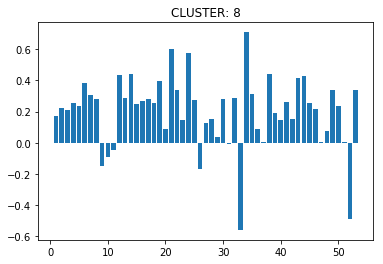

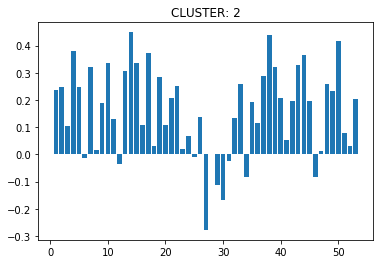

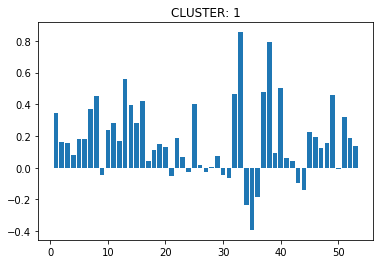

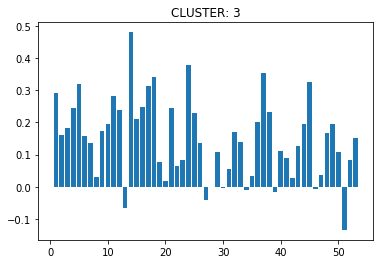

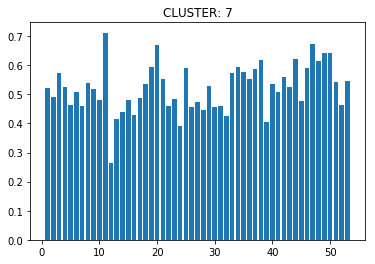

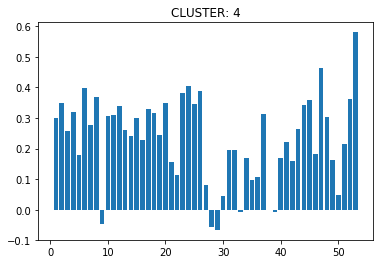

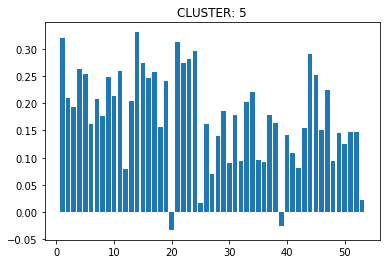

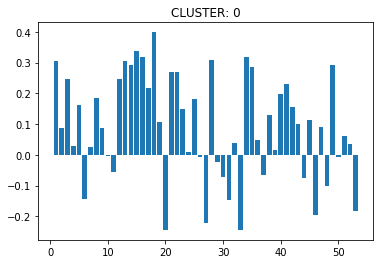

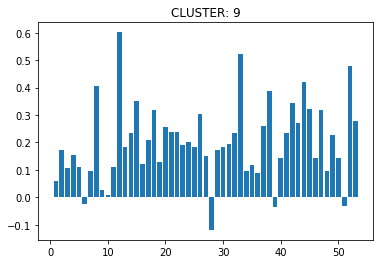

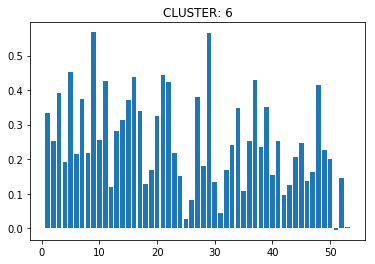

In [4]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

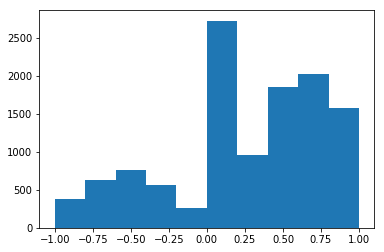

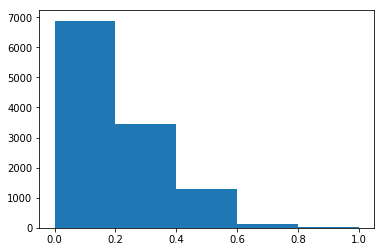

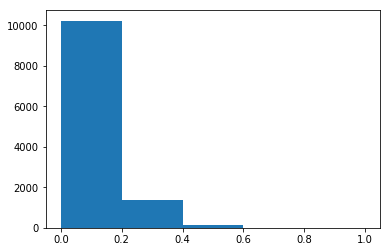

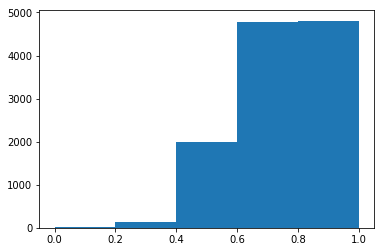

In [5]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

In [6]:
x1 = data[data["labels"] == 3]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

1172


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.876e+03, 6.900e+01, 2.000e+01, 9.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   4. ,  168.8,  333.6,  498.4,  663.2,  828. ,  992.8, 1157.6,
        1322.4, 1487.2, 1652. ]),
 <a list of 10 Patch objects>)

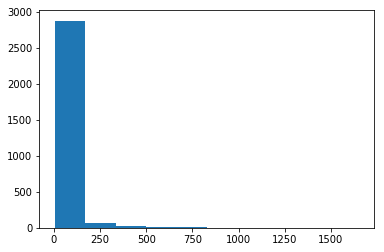

In [7]:
plt.hist(stemmed_words)

In [9]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

In [10]:
res1.columns

Index(['vaderScore', '10', '100', '1000', '10000', '10am', '10pm', '11',
       '1100', '11am',
       ...
       'yet', 'york', 'youd', 'young', 'your', 'youtub', 'youv', 'zero',
       'zogbi', 'zuckerman'],
      dtype='object', length=2089)

# Hierarchical

In [ ]:
from sklearn.cluster import AgglomerativeClustering
sil = []
for c in range(40,85):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

In [ ]:
res1.columns

In [ ]:
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=85) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_

In [ ]:
d = silhouette_score(res1, labels,metric='cosine')
print(d)

In [ ]:
res1["labels"] = labels
dataWithText["labels"] = labels

In [ ]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()

# K means

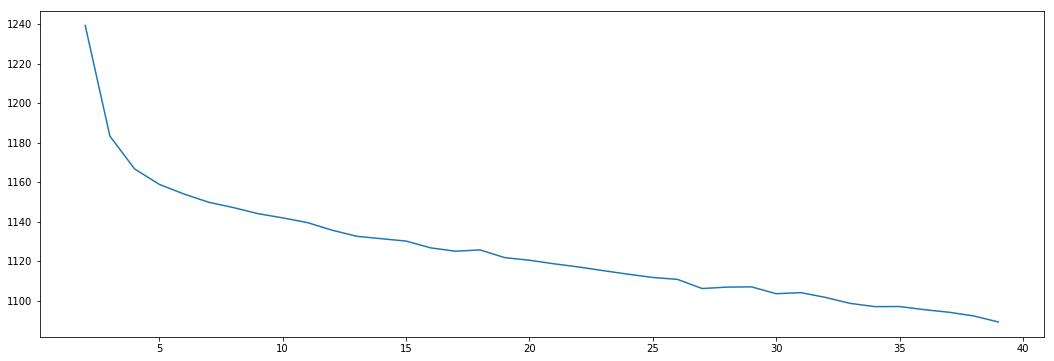

CPU times: user 11min 6s, sys: 17min 13s, total: 28min 19s
Wall time: 2min 17s


In [11]:
%%time
sse_list = list()
max_k = 40
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [12]:
#6 per il label 1 (15 cluster)
#monthe vader alzano la silhouette

#per label 2 week year peggiora sse ma aumenta silhouette
#solo vader e tfidf abbassano di un botto l'sse per label 2


#sembra che usare week year peggiori l'sse ma aumenti di molto la silhouette. Come interpretare? cosa preferire?
true_k =5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

1159.032638180863
0.25879056972186654


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  2  lunghezza  325
NUMBER OF TOPICS FOR CLUSTER  2  :  1


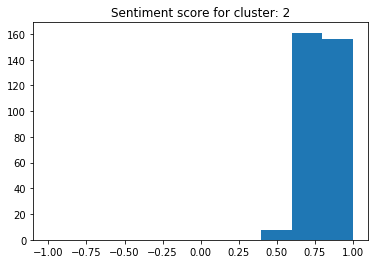

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 9]


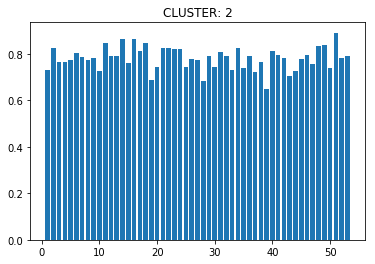

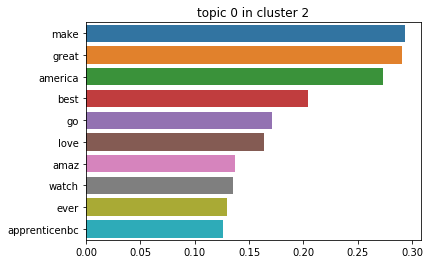

cluster  0  lunghezza  242
NUMBER OF TOPICS FOR CLUSTER  0  :  2


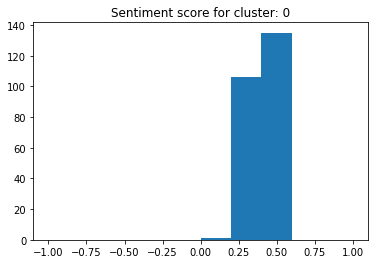

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50, 52, 11, 12, 35, 36]


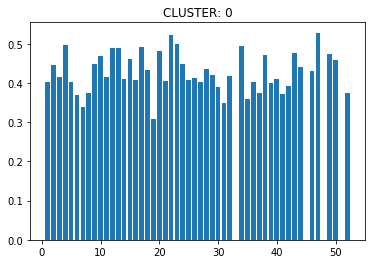

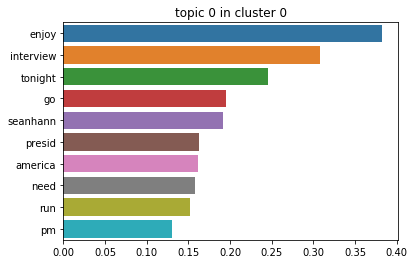

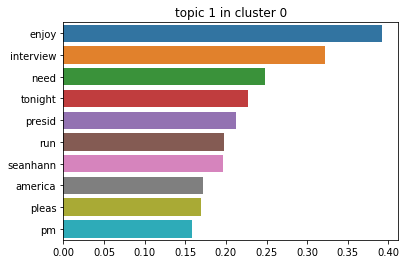

cluster  1  lunghezza  167
NUMBER OF TOPICS FOR CLUSTER  1  :  4


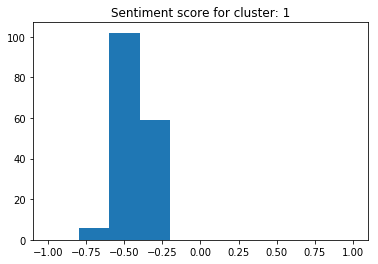

[1, 2, 3, 4, 5, 6, 7, 9, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 8, 11, 12, 13, 18, 21, 31, 33, 36, 40, 48]


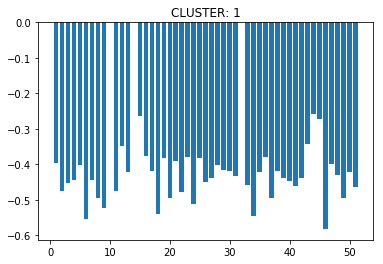

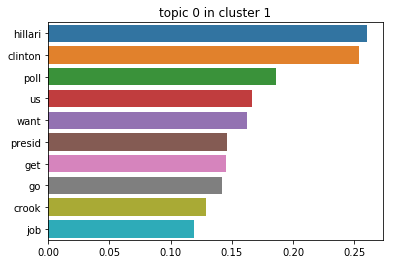

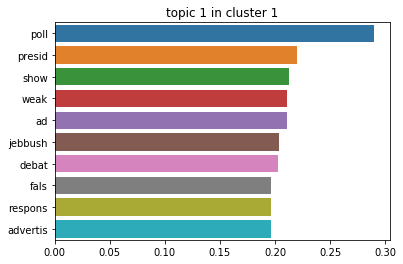

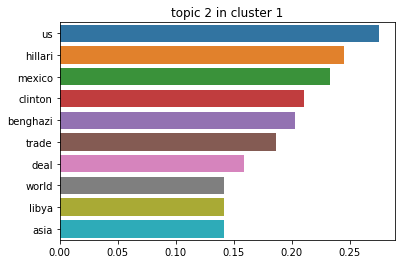

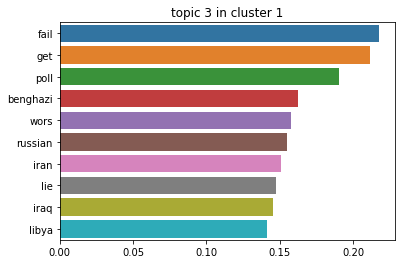

cluster  3  lunghezza  283
NUMBER OF TOPICS FOR CLUSTER  3  :  1


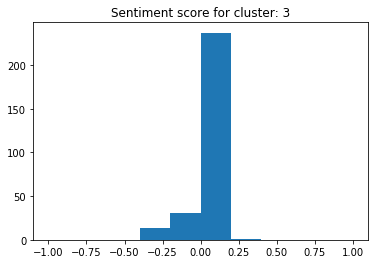

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 24, 46]


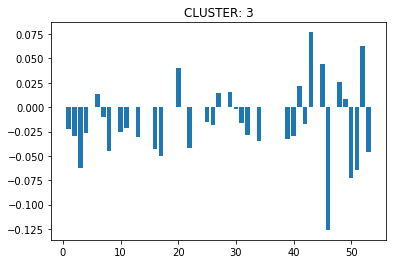

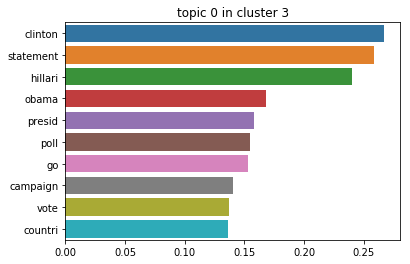

cluster  4  lunghezza  155
NUMBER OF TOPICS FOR CLUSTER  4  :  7


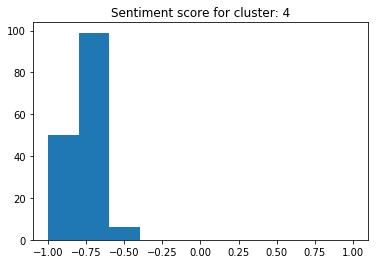

[2, 3, 4, 6, 9, 13, 14, 15, 19, 20, 22, 26, 27, 28, 30, 31, 32, 34, 35, 36, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5, 7, 8, 10, 11, 12, 16, 21, 23, 24, 25, 29, 33, 37, 38, 39]


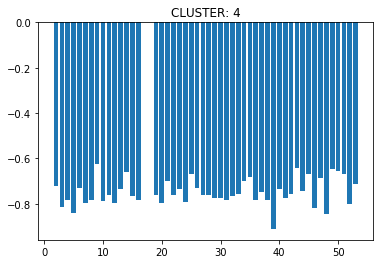

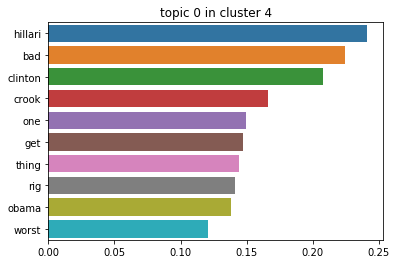

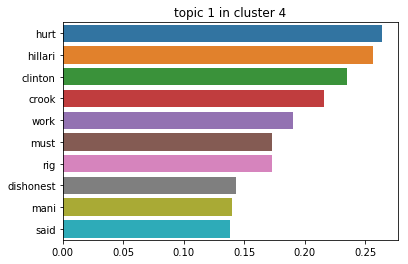

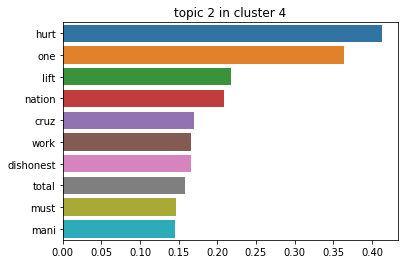

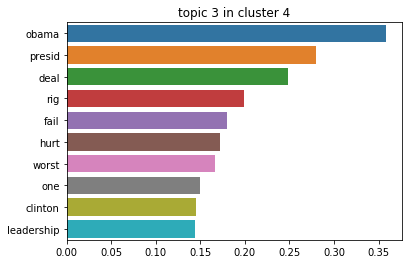

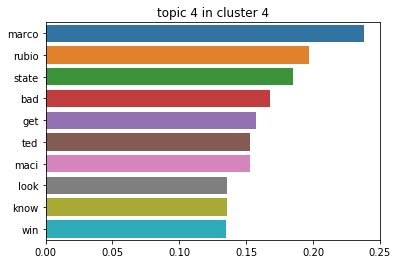

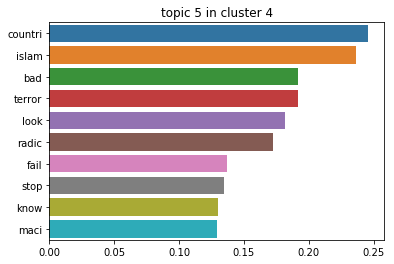

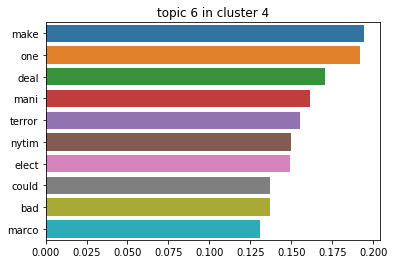

In [15]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["week_year"].unique().tolist())
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()